In [37]:
from SimulatedAnnealing import Annealer
import matplotlib.pyplot as plt
import rustworkx as rx
import numpy as np

# Demo: SimulatedAnnealing for the MaxCut Problem

Here we will use the `Annealer()` class along with its method `.maxcut()` to solve the MaxCut problem in both the weighted and unweighted cases. 

## The Unweighted Case

We will find the partition of the graph corresponding to the maximum cut in the unweighted case. 

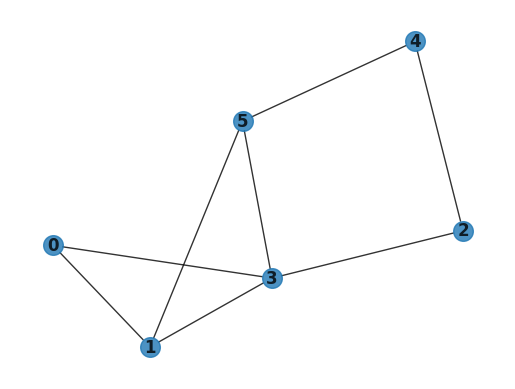

In [44]:
edges = [(0, 1, 1.0), (0, 3, 1.0), (1, 3, 1.0), (1, 5, 1.0), (2, 3, 1.0), (2, 4, 1.0), (3, 5, 1.0), (4, 5, 1.0)]

def draw_graph(edges, edge_labels=False, color_nodes=None):
    if color_nodes is not None:
        colors = ["tab:blue" if i == 0 else "tab:red" for i in color_nodes]
    else:
        colors = None
    max_node = max(max(edge[:-1]) for edge in edges) + 1
    graph = rx.PyGraph()
    graph.add_nodes_from(np.arange(0, max_node, 1))
    graph.add_edges_from(edges)
    pos, default_axes = rx.spring_layout(graph), plt.axes(frameon=True)
    rx.visualization.mpl_draw(graph, node_size=200, alpha=0.8, pos=pos, with_labels=True, font_weight='bold', edge_labels=str if edge_labels else None, node_color=colors)

draw_graph(edges)

For this graph of six nodes, solutions will be of the form $x = (x_0, x_1, x_2, x_3, x_4, x_5)$ where each $x_i$ is either $0$ or $1$, depending on which set of the partition the node belongs to. This is a small problem, so we will rank each possible solution via brute force, to see if later the `.maxcut()` method for `Annealer()` finds the best one. In order to do this, we define the function `f(x)` giving a value to each cut.

<BarContainer object of 32 artists>

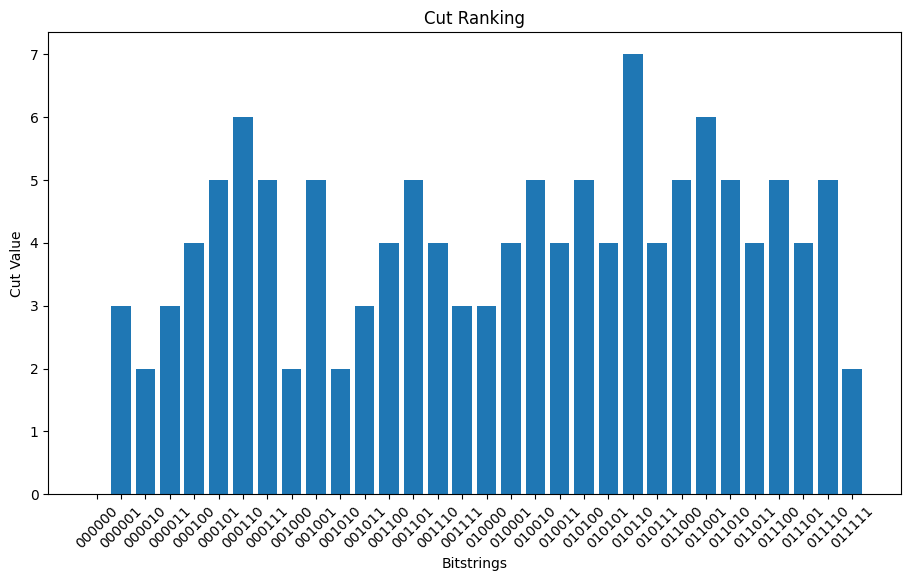

In [48]:
def f(x, edges):
    tot = 0
    for edge in edges:
        i, j, w = edge
        tot += w * (x[i] + x[j] - 2*x[i]*x[j])
    return tot

bitstrings = [np.binary_repr(i, 6) for i in range(2**6)]
costs = []
for b in bitstrings:
    x = np.array(list(b), dtype=int)
    cost = f(x, edges)
    costs.append(cost)

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Cut Ranking")
plt.xlabel("Bitstrings")
plt.ylabel("Cut Value")
ax.bar(bitstrings[:len(bitstrings)//2], costs[:len(costs)//2], color="tab:blue")  # Only include half of the solutions, problem is symmetric.

We can see that there is exactly one solution achieveing the maximal possible cut value of $7$ and that is $x = (0, 1, 0, 1, 1, 0)$. This is of course equivalent to $x = (1, 0, 1, 0, 0, 1)$, but `Annealer().maxcut()` has been written in such a way to treat them as the same (it only considers solutions for which $x_0 = 0$). Next, we will try to find this solution using Simulated Annealing. We will first try with just a single shot. 

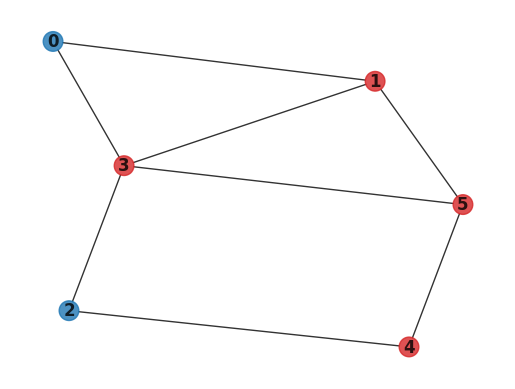

Solution: [0 1 0 1 1 1] 
Energy: -4.0


In [45]:
ann = Annealer()
solution, xs, Es = ann.maxcut(edges, draw=True)
print(f"Solution: {solution} \nEnergy: {Es[-1]}")

As we can see, the anneler failed to find the maximal cut, so instead we may choose to adjust the anneaer parameters. We slow the cooling rate down by increasing `alpha` from $0.99$ to $0.995$. We also increase `max_temp` from $20$ to $30$.

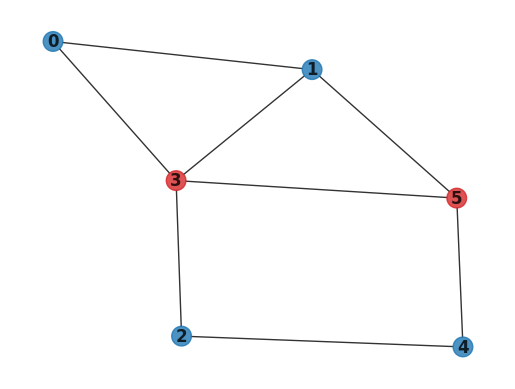

Solution: [0 0 0 1 0 1] 
Energy: -5.0


In [46]:
ann_ = Annealer(alpha=0.995, max_temp=30)
solution, xs, Es = ann_.maxcut(edges, draw=True)
print(f"Solution: {solution} \nEnergy: {Es[-1]}")

Again, this has not worked and so we will employ a standard practice in Simulated Annealing. The idea is to run the algorithm multiple times, and select the best solution with the hope that we find the optimal one within our iterations.

Solution: [0 1 0 1 1 0] 
Energy: -7.0


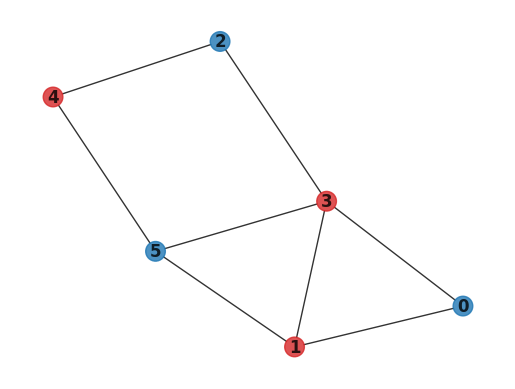

In [47]:
solutions = []
for i in range(30):
    solution, xs, Es = ann_.maxcut(edges)
    solutions.append((solution, Es[-1]))

sort_solutions = sorted(solutions, key=lambda x: x[1])
x, E = sort_solutions[0]
draw_graph(edges, color_nodes=x)
print(f"Solution: {x} \nEnergy: {E}")


We have found the optimal solution for the unweighted MaxCut problem.

## The Weighted Case

We can also solve the problem in much the same way if we now choose to add weights to the edges. Instead of maximising the number of cuts, we now aim at maximising the value of the cut.

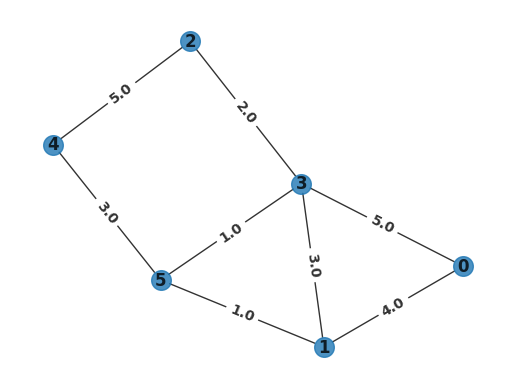

In [52]:
weighted_edges = [(e[0], e[1], np.random.choice([1.0, 2.0, 3.0, 4.0, 5.0])) for e in edges]
draw_graph(weighted_edges, edge_labels=True)

We can once again plot the value of each cut.

<BarContainer object of 32 artists>

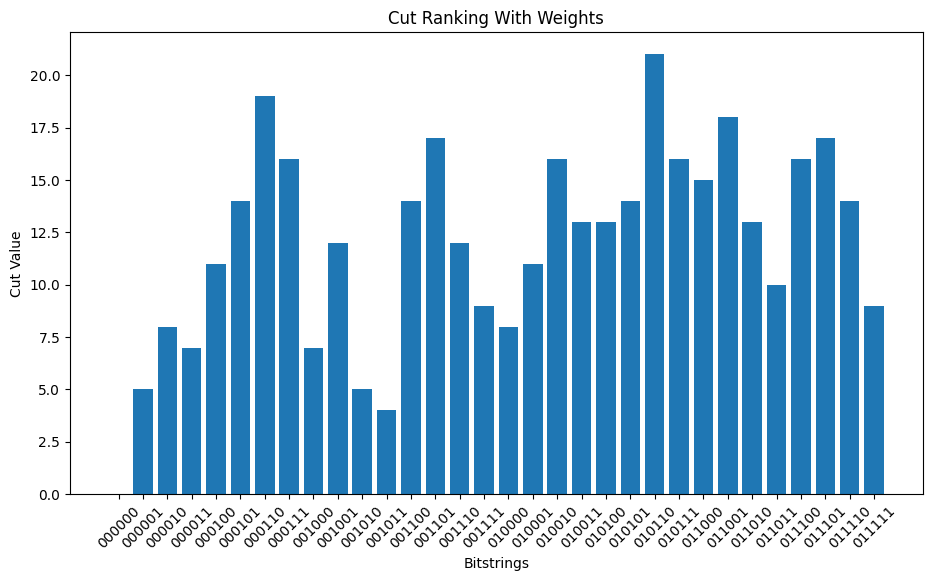

In [53]:
bitstrings = [np.binary_repr(i, 6) for i in range(2**6)]
costs = []
for b in bitstrings:
    x = np.array(list(b), dtype=int)
    cost = f(x, weighted_edges)
    costs.append(cost)

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Cut Ranking With Weights")
plt.xlabel("Bitstrings")
plt.ylabel("Cut Value")
ax.bar(bitstrings[:len(bitstrings)//2], costs[:len(costs)//2], color="tab:blue")  # Only include half of the solutions, problem is symmetric.

The maximum cut value is now larger than it used to be, we will try to find the optimal cut. 

Solution: [0 1 0 1 1 0] 
Energy: -21.0


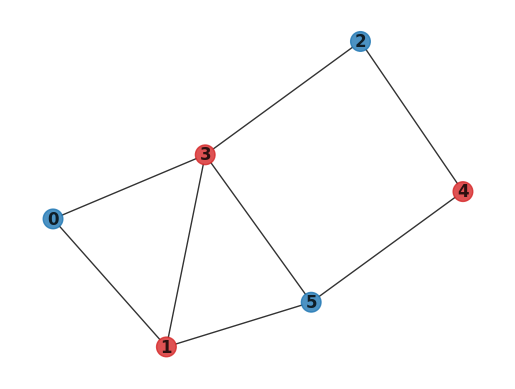

In [58]:
solutions = []
for i in range(50):
    solution, xs, Es = ann.maxcut(weighted_edges)
    solutions.append((solution, Es[-1]))

sort_solutions = sorted(solutions, key=lambda x: x[1])
x, E = sort_solutions[0]
draw_graph(edges, color_nodes=x)
print(f"Solution: {x} \nEnergy: {E}")